<a href="https://colab.research.google.com/github/CristinaMarsh/Learning_/blob/main/TStool/Gluonts_day4_official_Tuning_models_with_Optun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gluonts
!pip install mxnet-cu101

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 16.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 360.0 MB 16 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [1]:
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [3]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers']


In [4]:
dataset = get_dataset("m4_hourly")

In [5]:
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Recommended prediction horizon: 48
Frequency of the time series: H


In [6]:
dataset

TrainDatasets(metadata=MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='414')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=48), train=DatasetCollection(datasets=[Map(data=JsonLinesFile(path=PosixPath('/root/.mxnet/gluon-ts/datasets/m4_hourly/train/data.json.gz')))], interleave=False), test=DatasetCollection(datasets=[Map(data=JsonLinesFile(path=PosixPath('/root/.mxnet/gluon-ts/datasets/m4_hourly/test/data.json.gz')))], interleave=False))

In [9]:
to_pandas(next(iter(dataset.train)))

1750-01-01 00:00    605.0
1750-01-01 01:00    586.0
1750-01-01 02:00    586.0
1750-01-01 03:00    559.0
1750-01-01 04:00    511.0
                    ...  
1750-01-29 23:00    790.0
1750-01-30 00:00    784.0
1750-01-30 01:00    752.0
1750-01-30 02:00    739.0
1750-01-30 03:00    684.0
Freq: H, Length: 700, dtype: float32

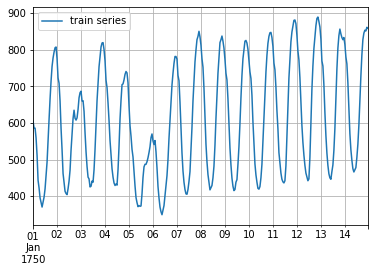

In [7]:
to_pandas(next(iter(dataset.train)))[:14 * 24].plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

In [12]:
! pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 17.9 MB/s 
     |████████████████████████████████| 209 kB 43.5 MB/s 
     |████████████████████████████████| 81 kB 8.5 MB/s 
     |████████████████████████████████| 78 kB 6.1 MB/s 
     |████████████████████████████████| 146 kB 4.4 MB/s 
     |████████████████████████████████| 112 kB 42.6 MB/s 
     |████████████████████████████████| 49 kB 5.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=8d496a0ffc15812e6d229ea78cc494369122a35dafb8bb52b9fd2455fa06a62c
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [14]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 18.2 MB/s 
     |████████████████████████████████| 140 kB 47.5 MB/s 
     |████████████████████████████████| 419 kB 43.2 MB/s 
     |████████████████████████████████| 596 kB 38.8 MB/s 
     |████████████████████████████████| 1.1 MB 48.7 MB/s 
     |████████████████████████████████| 144 kB 59.8 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████████████████████████| 271 kB 72.0 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Tuning parameters of DeepAR estimator

In [8]:
import optuna
import torch
from gluonts.torch.model.deepar import DeepAREstimator #Here chose torch.model.deepAREstimator
from gluonts.mx import Trainer
from gluonts.evaluation import Evaluator

In [10]:
class DeepARTuningObjective:
    def __init__(self, dataset, prediction_length, freq, metric_type="mean_wQuantileLoss"):
        self.dataset = dataset
        self.prediction_length = prediction_length
        self.freq = freq
        self.metric_type = metric_type

        entry_split = [self.split_entry(entry) for entry in self.dataset]
        self.entry_pasts = [entry[0] for entry in entry_split]
        self.entry_futures = [entry[1] for entry in entry_split]

    def get_params(self, trial) -> dict:
        return {
            "num_layers": trial.suggest_int("num_layers", 1, 5),
            "hidden_size": trial.suggest_int("hidden_size", 10, 50),
        }

    def split_entry(self, entry):
        entry_past = {}
        for key, value in entry.items():
            if key == "target":
                entry_past[key] = value[: -self.prediction_length]
            else:
                entry_past[key] = value

        df = pd.DataFrame(
            entry['target'],
            columns=[entry['item_id']],
            index=pd.period_range(
                start=entry['start'],
                periods=len(entry['target']),
                freq=self.freq
            )
        )

        return entry_past, df[-self.prediction_length:]

    def __call__(self, trial):
        params = self.get_params(trial)
        estimator = DeepAREstimator(
            num_layers=params['num_layers'],
            hidden_size=params['hidden_size'],
            prediction_length=self.prediction_length,
            freq=self.freq,
            trainer_kwargs={
                "enable_progress_bar": False,
                "enable_model_summary": False,
                "max_epochs": 10,
            }
        )


        predictor = estimator.train(self.entry_pasts, cache_data=True)
        forecast_it = predictor.predict(self.entry_pasts)

        forecasts = list(forecast_it)

        evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
        agg_metrics, item_metrics = evaluator(self.entry_futures, forecasts, num_series=len(self.dataset))
        return agg_metrics[self.metric_type]

In [13]:
dataset.train

DatasetCollection(datasets=[Map(data=JsonLinesFile(path=PosixPath('/root/.mxnet/gluon-ts/datasets/m4_hourly/train/data.json.gz')))], interleave=False)

In [12]:
next(iter(dataset.train))

{'feat_static_cat': array([0], dtype=int32),
 'item_id': 0,
 'start': Period('1750-01-01 00:00', 'H'),
 'target': array([605., 586., 586., 559., 511., 443., 422., 395., 382., 370., 383.,
        397., 420., 455., 493., 554., 610., 666., 715., 755., 778., 794.,
        806., 808., 776., 723., 709., 660., 585., 527., 462., 437., 413.,
        407., 404., 420., 441., 471., 526., 571., 612., 635., 613., 608.,
        614., 637., 669., 683., 687., 660., 661., 632., 573., 521., 481.,
        452., 447., 425., 427., 441., 438., 472., 528., 596., 661., 708.,
        754., 781., 808., 819., 820., 801., 770., 717., 697., 655., 607.,
        552., 512., 475., 452., 436., 429., 433., 430., 472., 536., 611.,
        662., 705., 707., 718., 733., 741., 737., 710., 647., 593., 564.,
        528., 507., 466., 428., 396., 382., 371., 374., 372., 373., 406.,
        451., 480., 487., 487., 494., 505., 519., 535., 560., 570., 551.,
        541., 552., 521., 477., 426., 395., 370., 357., 349., 362., 374.,

In [14]:
import time
start_time = time.time()
study = optuna.create_study(direction="minimize")
study.optimize(
    DeepARTuningObjective(dataset.train, dataset.metadata.prediction_length, dataset.metadata.freq),
    n_trials=5
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
print(time.time() - start_time)

[I 2022-07-07 21:33:56,862] A new study created in memory with name: no-name-e9e43ea9-09ca-46a0-bd37-f35cd40149bb
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_ze

Number of finished trials: 5
Best trial:
  Value: 0.049934732952207274
  Params: 
    num_layers: 4
    hidden_size: 50
352.378821849823


## Re-training the model
After getting the best hyperparameters by optuna, you can set them into the DeepAR estimator to re-train the model on the whole training subset we consider here.

In [15]:
estimator = DeepAREstimator(
    num_layers=trial.params["num_layers"],
    hidden_size=trial.params["hidden_size"],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.freq,
    trainer_kwargs={
        "enable_progress_bar": False,
        "enable_model_summary": False,
        "max_epochs": 10,
    }
)

After specifying our estimator with all the necessary hyperparameters we can train it using our training dataset train_subset by invoking the train method of the estimator. The training algorithm returns a fitted model (or a Predictor in GluonTS parlance) that can be used to obtain forecasts.

In [16]:
predictor = estimator.train(dataset.train, cache_data=True)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
INFO:pytorch_lightning

## Visualize and evaluate forecasts
With a predictor in hand, we can now predict the last window of the test dataset and evaluate our model’s performance.

GluonTS comes with the make_evaluation_predictions function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:

- Removes the final window of length prediction_length of the test dataset that we want to predict移除我们要预测的测试数据集的最后一个长度为prediction_length的窗口
- The estimator uses the remaining data to predict (in the form of sample paths) the “future” window that was just removed估算器使用剩余的数据来预测（以样本路径的形式）刚刚删除的 "未来 "窗口

- The forecasts are returned, together with ground truth values for the same time range (as python generator objects)预测结果与同一时间范围内的基础真实值一起返回（作为python生成器对象）。

In [19]:
from gluonts.evaluation import make_evaluation_predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor
)

In [20]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [21]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

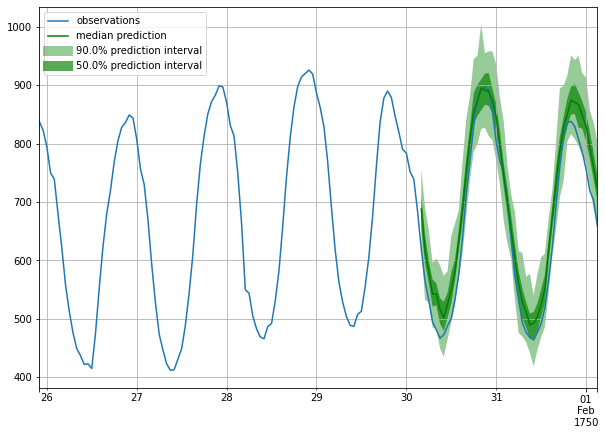

In [22]:
plot_prob_forecasts(tss[0], forecasts[0])

## Quantitative
We can also evaluate the quality of our forecasts numerically. In GluonTS, the Evaluator class can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).

In [23]:
from gluonts.evaluation import Evaluator

In [24]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)


Running evaluation: 414it [00:00, 10771.90it/s]


In [25]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 4951328.627908117,
    "abs_error": 9306642.709573746,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 4.175822464810799,
    "MAPE": 0.19722115488995867,
    "sMAPE": 0.16208421747873564,
    "MSIS": 27.69610063288209,
    "QuantileLoss[0.1]": 4589631.002118968,
    "Coverage[0.1]": 0.1674718196457327,
    "QuantileLoss[0.5]": 9306642.858373642,
    "Coverage[0.5]": 0.6825181159420289,
    "QuantileLoss[0.9]": 4267563.337557029,
    "Coverage[0.9]": 0.8816425120772947,
    "RMSE": 2225.1581130131217,
    "NRMSE": 0.3037832319399573,
    "ND": 0.06393731360237634,
    "wQuantileLoss[0.1]": 0.031531099437157775,
    "wQuantileLoss[0.5]": 0.06393731462464246,
    "wQuantileLoss[0.9]": 0.02931847111211221,
    "mean_absolute_QuantileLoss": 6054612.3993498795,
    "mean_wQuantileLoss": 0.041595628391304144,
    "MAE_Coverage": 0.08944914117015564,
    "OWA": NaN
}


In [26]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0.0,1754.649902,1771.133789,31644.0,659.250000,42.371302,0.870840,0.060458,0.058184,0.055971,4.859754,518.780579,0.333333,1771.133728,0.895833,825.809888,1.000000
1,1.0,273928.270833,24805.832031,124149.0,2586.437500,165.107988,3.130001,0.215038,0.192020,0.199807,30.052289,24338.397900,0.937500,24805.832031,1.000000,7113.391064,1.000000
2,2.0,49424.302083,8367.559570,65030.0,1354.791667,78.889053,2.209738,0.114465,0.124510,0.128672,34.737868,2372.536182,0.000000,8367.559875,0.125000,9540.901050,0.375000
3,3.0,208089.645833,17559.128906,235783.0,4912.145833,258.982249,1.412511,0.079156,0.075438,0.074472,8.012938,11868.152441,0.291667,17559.130127,0.708333,7346.347559,0.895833
4,4.0,47106.937500,7359.845215,131088.0,2731.000000,200.494083,0.764761,0.048226,0.049698,0.056144,4.341211,2848.810962,0.000000,7359.845093,0.375000,5409.664893,0.729167


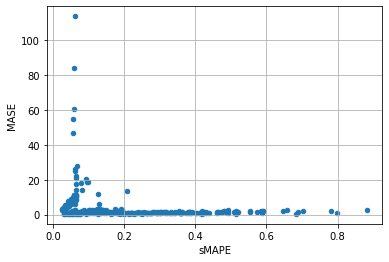

In [27]:
item_metrics.plot(x='sMAPE', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()